# Effect of different "link" functions in interaction with corridor width

I'll try to use python directly instead of going through R. I guess it will help me in the long run for this project.

Load libraries etc.:

In [134]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import itertools
import operator
import numpy as np
import math
%matplotlib inline 
plt.ion()

import os
os.getcwd()
os.chdir('M:\\My Documents\\E\\Work\\Projects\\RenewableReindeer\\reindeers_git\\simulations')
    
from grid_manager import Grid
from habitat_analysis import HabitatAnalysis

os.chdir('M:\\My Documents\\E\\Work\\Projects\\RenewableReindeer\\reindeers_git\\p_analysis')

## Landscape simulation function:

In [135]:
def perm_wall_sim(grid_shape = [30,60], Q=1, A=0.5, ww=3, wp=0.5, cw=[3,3], cp=[0.35,0.7]):
   "simulate a permeable wall"
   # 1. initialize landscape
   n_rows,n_cols = grid_shape
   N = n_rows*n_cols
   qualities = np.ones((N,))*Q
   g = Grid(shape=grid_shape, qualities=qualities)
   g.A = A * g.A

   # 2. compute the wall
   wpt = int(math.floor(n_cols*wp)-math.ceil(ww/2))
   xs = range(wpt, wpt+ww)
    
   # 3. compute the corridors
   for i in range(len(cw)):
       cpt=int(math.floor(n_rows*cp[i])-math.ceil(cw[i]/2))
       if i == 0:
           ys = range(cpt)
       else:
           ys=ys+range(max(ys)+1+cw[i-1], cpt)
   ys=ys+range(max(ys)+1+cw[i], n_rows)
    
   impossible_nodes = list(itertools.product(ys,xs))
   g.set_impossible_nodes(impossible_nodes)
   return [g]

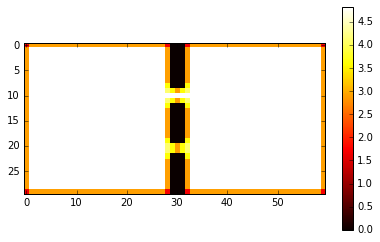

In [136]:
###Check
g = perm_wall_sim(cw=[3,2])[0]
g.plot_outdegrees()

## parameter sweep:

In [153]:
#vary the width of the corridors
lands = [(0.5,0,0), (0.5,1,0), (0.5,4,0), (0.5,4,1), (0.5,4,4)]
#vary also the position of the wall in the landscape
lands = [(0.25,0,0), (0.25,1,0), (0.25,4,0), (0.25,4,1), (0.25,4,4), (0.5,0,0), (0.5,1,0), (0.5,4,0), (0.5,4,1), (0.5,4,4)]

In [159]:
g = perm_wall_sim(wp=lands[1][0],cw=[lands[1][1],lands[1][2]])[0]

In [172]:
#l_a_to_c = ['minus_log', 'inverse', 'inverse_minus_1', 'one_minus']
#l_d_to_k = ['inverse', 'inverse_of_plus_1', 'exp_minus', 'hard_cap', 'soft_cap', 'max_minus_distance']
l_a_to_c = ['minus_log']
l_d_to_k = ['inverse']
lands_id = range(len(lands))
beta = [3,1,0.1, 0.01]

In [173]:
params=list(itertools.product(lands_id, l_a_to_c, l_d_to_k, beta))
params[0:3]

[(0, 'minus_log', 'inverse', 3),
 (0, 'minus_log', 'inverse', 1),
 (0, 'minus_log', 'inverse', 0.1)]

In [174]:
N = 30*60
#a_to_c = 'minus_log'
a_to_c = params[0][1]
#d_to_k = 'exp_minus'
d_to_k = params[0][2]

landscape_LC = \
HabitatAnalysis(g, sampling_method='qualities', n_landmarks=N,\
                similarity_measure='least_cost', affinity_to_cost=a_to_c,\
                distance_to_similarity=d_to_k)
landscape_LC.compute_similarities()

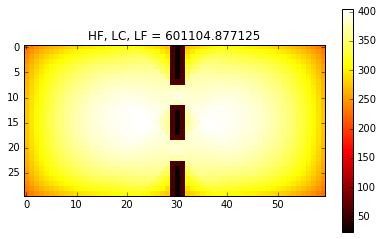

In [175]:
HFs_LC = landscape_LC.compute_habitat_functionalities()
LF_LC = np.sum(HFs_LC)
g.plot(HFs_LC, title="HF, LC, LF = " + str(LF_LC))

In [176]:
LF = []
for j in range(4):
    g = perm_wall_sim(wp=lands[j][0],cw=[lands[j][1],lands[j][2]])[0]

    N = 30*60
    a_to_c = params[1][1]
    d_to_k = params[1][2]

    landscape_LC = \
    HabitatAnalysis(g, sampling_method='qualities', n_landmarks=N,\
                    similarity_measure='least_cost', affinity_to_cost=a_to_c,\
                    distance_to_similarity=d_to_k)
    landscape_LC.compute_similarities()

    HFs_LC = landscape_LC.compute_habitat_functionalities()
    LF_LC = np.sum(HFs_LC)
    LF.append(LF_LC)

LF

[480586.95916077471,
 568367.73273772001,
 585539.77194131166,
 592939.49760063423]

In [177]:
LF-min(LF)

array([      0.        ,   87780.77357695,  104952.81278054,
        112352.53843986])

In [178]:
(LF-min(LF))/min(LF)

array([ 0.        ,  0.18265326,  0.21838465,  0.23378191])

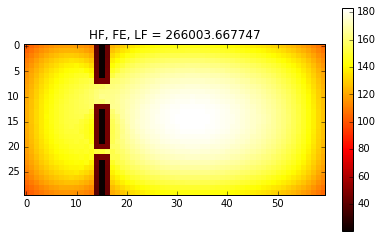

In [180]:
landscape_FE = \
HabitatAnalysis(g, sampling_method='qualities', n_landmarks=N,\
                similarity_measure='free_energy', beta=3, \
                affinity_to_cost=a_to_c, distance_to_similarity=d_to_k)
landscape_FE.compute_similarities()

HFs_FE = landscape_FE.compute_habitat_functionalities()
LF_FE = np.sum(HFs_FE)
g.plot(HFs_FE, title="HF, FE, LF = " + str(LF_FE))

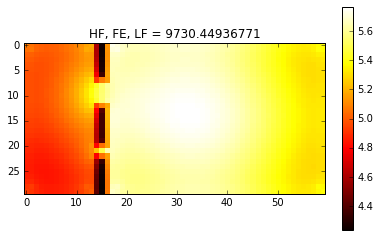

In [181]:
landscape_FE = \
HabitatAnalysis(g, sampling_method='qualities', n_landmarks=N,\
                similarity_measure='free_energy', beta=0.01, \
                affinity_to_cost=a_to_c, distance_to_similarity=d_to_k)
landscape_FE.compute_similarities()

HFs_FE = landscape_FE.compute_habitat_functionalities()
LF_FE = np.sum(HFs_FE)
g.plot(HFs_FE, title="HF, FE, LF = " + str(LF_FE))

In [182]:
#sweep
LF = []
for i in range(len(params)):
#for i in range(3):
    j = params[i][0]
    g = perm_wall_sim(wp=lands[j][0],cw=[lands[j][1],lands[j][2]])[0]

    N = 30*60
    a_to_c = params[i][1]
    d_to_k = params[i][2]
    beta = params[i][3]

    landscape_FE = HabitatAnalysis(g, sampling_method='qualities', n_landmarks=N, \
                                   similarity_measure='free_energy', beta=beta, \
                                   affinity_to_cost=a_to_c, distance_to_similarity=d_to_k)
    landscape_FE.compute_similarities()

    HFs_FE = landscape_FE.compute_habitat_functionalities()
    LF_FE = np.sum(HFs_FE)
    LF.append(LF_FE)

LF

[217122.06007798717,
 123988.86265137306,
 32815.58473000821,
 7977.7694297686539,
 256540.03831143933,
 145518.55304623145,
 38219.810082098687,
 9283.2798766821434,
 261421.7221172358,
 148098.03595971083,
 39212.510022453171,
 9646.0449086857225,
 266003.66774731252,
 150810.04426795992,
 39784.418497170642,
 9730.4493677055616,
 269648.96531462343,
 152739.0716240094,
 40407.205570883336,
 9895.1002018553918,
 201457.43245215766,
 115320.03411280816,
 30408.689992308282,
 7333.267882592414,
 253416.13969716211,
 143631.58892964723,
 37518.384704409997,
 9038.7447571583689,
 259018.14262930871,
 146624.94105715782,
 38739.249336317909,
 9505.4341376798657,
 264242.53677589737,
 149777.6590679884,
 39414.494309789487,
 9612.5184454861592,
 268304.89230066346,
 151951.43389283249,
 40152.304981256551,
 9821.7143467008136]

In [183]:
import json
f = open('M:\\My Documents\\E\\Work\\Projects\\RenewableReindeer\\reindeers_git\\p_analysis\\output.txt', 'w')
json.dump(LF, f)
f.close()

In [184]:
f = open('M:\\My Documents\\E\\Work\\Projects\\RenewableReindeer\\reindeers_git\\p_analysis\\output.txt', 'r')
LFr = json.load(f)
f.close()
LFr

[217122.06007798717,
 123988.86265137306,
 32815.58473000821,
 7977.769429768654,
 256540.03831143933,
 145518.55304623145,
 38219.81008209869,
 9283.279876682143,
 261421.7221172358,
 148098.03595971083,
 39212.51002245317,
 9646.044908685722,
 266003.6677473125,
 150810.04426795992,
 39784.41849717064,
 9730.449367705562,
 269648.96531462343,
 152739.0716240094,
 40407.205570883336,
 9895.100201855392,
 201457.43245215766,
 115320.03411280816,
 30408.689992308282,
 7333.267882592414,
 253416.1396971621,
 143631.58892964723,
 37518.38470441,
 9038.744757158369,
 259018.1426293087,
 146624.94105715782,
 38739.24933631791,
 9505.434137679866,
 264242.5367758974,
 149777.6590679884,
 39414.49430978949,
 9612.51844548616,
 268304.89230066346,
 151951.4338928325,
 40152.30498125655,
 9821.714346700814]

In [185]:
import pandas as pd
df=pd.DataFrame(params)
df[4] = LFr
df.columns = ['ls', 'ac', 'dk','beta','lf']
grouped = df.groupby('beta')

In [186]:
df['incr'] = grouped['lf'].apply(lambda x: 100*(x-min(x)))
df['pc_incr'] = grouped['lf'].apply(lambda x: 100*(x-min(x))/min(x))

What we would expect is that with higher beta, the biggest changes are made from ls 0 to 1 and 2, when we open progressively more corridors. However, with high beta we expect only marginal gain from 2 to 3, whereas we would expect a continuous increase with lower betas, also from 2 to 3.

Below we see that for this type of transformation this is not the case. Higher beta values benefit more from an increase in connectivity, irrespective from the width of the corridor.

In [187]:
df.sort_values(by=['beta', 'ls'], ascending=[False,True])

ls         ac       dk  beta             lf          incr    pc_incr
0    0  minus_log  inverse  3.00  217122.060078  1.566463e+06   7.775651
4    1  minus_log  inverse  3.00  256540.038311  5.508261e+06  27.342057
8    2  minus_log  inverse  3.00  261421.722117  5.996429e+06  29.765241
12   3  minus_log  inverse  3.00  266003.667747  6.454624e+06  32.039640
16   4  minus_log  inverse  3.00  269648.965315  6.819153e+06  33.849103
20   5  minus_log  inverse  3.00  201457.432452  0.000000e+00   0.000000
24   6  minus_log  inverse  3.00  253416.139697  5.195871e+06  25.791407
28   7  minus_log  inverse  3.00  259018.142629  5.756071e+06  28.572145
32   8  minus_log  inverse  3.00  264242.536776  6.278510e+06  31.165445
36   9  minus_log  inverse  3.00  268304.892301  6.684746e+06  33.181928
1    0  minus_log  inverse  1.00  123988.862651  8.668829e+05   7.517192
5    1  minus_log  inverse  1.00  145518.553046  3.019852e+06  26.186707
9    2  minus_log  inverse  1.00  148098.035960  3.277800e+06  28.423510
13   3  minus_log  inverse  1.00  150810.044268  3.549001e+06  30.775234
17   4  minus_log  inverse  1.00  152739.071624  3.741904e+06  32.447994
21   5  minus_log  inverse  1.00  115320.034113  0.000000e+00   0.000000
25   6  minus_log  inverse  1.00  143631.588930  2.831155e+06  24.550422
29   7  minus_log  inverse  1.00  146624.941057  3.130491e+06  27.146113
33   8  minus_log  inverse  1.00  149777.659068  3.445762e+06  29.879999
37   9  minus_log  inverse  1.00  151951.433893  3.663140e+06  31.764992
2    0  minus_log  inverse  0.10   32815.584730  2.406895e+05   7.915154
6    1  minus_log  inverse  0.10   38219.810082  7.811120e+05  25.687131
10   2  minus_log  inverse  0.10   39212.510022  8.803820e+05  28.951658
14   3  minus_log  inverse  0.10   39784.418497  9.375729e+05  30.832399
18   4  minus_log  inverse  0.10   40407.205571  9.998516e+05  32.880455
22   5  minus_log  inverse  0.10   30408.689992  0.000000e+00   0.000000
26   6  minus_log  inverse  0.10   37518.384704  7.109695e+05  23.380470
30   7  minus_log  inverse  0.10   38739.249336  8.330559e+05  27.395325
34   8  minus_log  inverse  0.10   39414.494310  9.005804e+05  29.615890
38   9  minus_log  inverse  0.10   40152.304981  9.743615e+05  32.042206
3    0  minus_log  inverse  0.01    7977.769430  6.445015e+04   8.788736
7    1  minus_log  inverse  0.01    9283.279877  1.950012e+05  26.591310
11   2  minus_log  inverse  0.01    9646.044909  2.312777e+05  31.538150
15   3  minus_log  inverse  0.01    9730.449368  2.397181e+05  32.689130
19   4  minus_log  inverse  0.01    9895.100202  2.561832e+05  34.934389
23   5  minus_log  inverse  0.01    7333.267883  0.000000e+00   0.000000
27   6  minus_log  inverse  0.01    9038.744757  1.705477e+05  23.256710
31   7  minus_log  inverse  0.01    9505.434138  2.172166e+05  29.620713
35   8  minus_log  inverse  0.01    9612.518445  2.279251e+05  31.080967
39   9  minus_log  inverse  0.01    9821.714347  2.488446e+05  33.933664

With
'minus_log' and 'exp_minus' it seems to be too local and only very small changes occur.

'one_minus' and 'exp_minus' it seems to be too local and only very small changes occur.

'one_minus' and 'max_minus_distance' we get the biggest changes for the lowest beta. Moreover, contrary to the expectation lower beta values benefit more from opening one corridor. I am however not sure that the max is not changing on the landscape.

'one_minus' and 'soft_cap' for the time being looks the best. We get up to 25% improvement in the functionality (low beta), largely due to the lower absolute functionality. The responses are as expected: high beta benefits more from added corridors, whereas low beta benefits (comparatively) more from wider corridors. 

'one_minus' and 'hard_cap' somewhat more pronounced results as with the soft_cap, but very similar in general.

'one_minus' and 'inverse_of_plus_1' similar to soft_cap.

'inverse_minus_1' and 'inverse_of_plus_1' seems not to work (FE), but not very promising either (on LC). Problem seems to be due to the ac-part.

Also, the 'inverse' for the ac-part is not very promissing.

